<font color='#524987'><h1 style="font-size:3.5em;">Single-protein simulation analysis<br>of lipid-protein interactions in<br>mitochondrial membranes</h1></font>
**<font color='#524987'>Delinyah Koning**</font><br>
<font color='#524987'>Molecular Dynamics, University of Groningen (2023)</font>

For computationally modeling the mitochondrion, the molecular dynamics trajectories should be properly produced and analysed.<br> 
The currently proposed method computes leaflet- and lipid-specific enrichment or depletion as a percentual deviation from a uniform distribution estimate value.

**Note: This is an example notebook.**

<div class="alert alert-block alert-warning"> We assume that quality control is conducted prior to further analysis (i.e., MSD, RMSD, RMSF, potential energy, temperature, pressure, et cetera) </div>

# <font color='#524987'>Environment Initialization</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import time
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
from IPython.display import Image
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os
import scipy.signal

<font color='#524987'><h2 style="font-size:1.3em;">Trajectory loading</h2></font>

Here, `u` is an object from a class, and is therefore an instance of the MDA Universe. We use `u` as the basis of our analyses, mainly for initial residue selection.

In [2]:
path = '/Users/delinyahkoning/downloads/7ck6/'
tpr = 'md.gro'
xtc = 'md.xtc'
u = mda.Universe(path+tpr, path+xtc)
prefix = os.path.splitext(os.path.basename(tpr))[0]

/Users/delinyahkoning/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/Users/delinyahkoning/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [3]:
output_folder = '.'
output_folder_2 = '.'
cwd = os.getcwd()
subfolder_name = os.path.basename(cwd)

In [4]:
lipid_types = ['POPC', 'SAPE', 'PAPI', 'POPS', 'POPA', 'CDL1']

In [5]:
prot = u.select_atoms('protein')
rest = u.select_atoms('not (protein or resname W)')

# <font color='#524987'>Wrapper class for trajectory processing</font>

<font color='#524987'><h2 style="font-size:1.3em;">Function: Converting MDA box dimensions to gromacs style</h2></font>

In [6]:
def mda_pbc_to_gro(m):
    """
    Converts a list of periodic boundary conditions (PBC) dimensions from the 
    MDA-style format to the GROMACS (.gro) style format.

    Parameters:
    m : list
        A list of six float values representing the MDA-style PBC dimensions. 
        The list follows the structure [a, b, c, alpha, beta, gamma], where:
            a, b, c: are the lengths of the box vectors,
            alpha: is the angle between vectors 'b' and 'c',
            beta: is the angle between vectors 'a' and 'c',
            gamma: is the angle between vectors 'a' and 'b'.
        All angle values are assumed to be in degrees.

    Returns:
    numpy.ndarray
        A 3x3 matrix representing the GROMACS (.gro) style PBC dimensions. The 
        returned array follows the structure [[xx, xy, xz], [yx, yy, yz], [zx, zy, zz]], where:
            xx, yy, zz: are the lengths of the box vectors along x, y, and z axes respectively,
            xy, xz, yx, yz, zx, zy: are the projections of the box vectors on the respective planes.
        
    This function computes the conversion using certain geometric relations among the input parameters.
    For more information on the conversion method, see:
    https://manual.gromacs.org/current/reference-manual/algorithms/periodic-boundary-conditions.html#some-useful-box-types
    and:
    https://docs.mdanalysis.org/1.0.1/_modules/MDAnalysis/lib/mdamath.html#triclinic_box
    """
    a, b, c, alpha, beta, gamma = m
    alpha, beta, gamma = np.array([alpha, beta, gamma]) * np.pi / 180

    xx = a
    xy = 0.0
    xz = 0.0
    yx = b * np.cos(gamma)
    yy = b * np.sin(gamma)
    yz = 0.0
    zx = c * np.cos(beta)
    zy = (c / np.sin(gamma)) * (np.cos(alpha) - np.cos(beta) * np.cos(gamma))
    zz = np.sqrt(c ** 2 - zx ** 2 - zy ** 2)

    return np.array([[xx, xy, xz], [yx, yy, yz], [zx, zy, zz]])

<font color='#524987'><h2 style="font-size:1.3em;">Function: Defining the periodic images giving shortest distances</h2></font>

In [7]:
def molbox_1(coords_ad, coords_bd, pbc_dd):
    '''
    Shifts all positions in `coords_bd` to have the shortest distance
    to any atom of `coords_ad` under periodic boundary conditions 
    defined by `pbc_dd`.

    Parameters:
    coords_ad : numpy.ndarray
        A two-dimensional array representing the positions of atoms in the 
        first molecule. Each row corresponds to a different atom and the columns 
        represent the x, y, and z coordinates respectively.
        
    coords_bd : numpy.ndarray
        A two-dimensional array representing the positions of atoms in the 
        second molecule. Each row corresponds to a different atom and the columns 
        represent the x, y, and z coordinates respectively.
        
    pbc_dd : numpy.ndarray
        A 3x3 matrix representing the periodic boundary conditions. This matrix 
        defines the dimensions of the periodic box in which the molecules reside.

    Returns:
        tuple of numpy.ndarray
            - Adjusted positions of `coords_bd` atoms (numpy.ndarray, shape identical to input arrays).
            - Euclidean distances from each adjusted atom in `coords_bd` to the nearest atom in `coords_ad` (numpy.ndarray, shape is (n,)).
    '''
    pbcinv_dd = np.linalg.inv(pbc_dd)
    ad = coords_ad @ pbcinv_dd
    bd = coords_bd @ pbcinv_dd
    
    nb = len(bd)
    
    # These are the shortest differences in box coordinates
    diff = np.divmod(ad[:, None] - bd[None, :] + 0.5, 1)[1] - 0.5
    
    # These are the lengths of the vectors in Cartesian space
    # For each atom the protein atom that is closest
    p = ((diff.reshape((-1, 3)) @ pbc_dd) ** 2).sum(axis=1).reshape((-1, nb)).argmin(axis=0)
    shift = diff[p, np.arange(nb)] @ pbc_dd
    
    return coords_ad[p] - shift, (shift ** 2).sum(axis=1) ** 0.5

<font color='#524987'><h2 style="font-size:1.3em;">Python class for trajectory handling</h2></font>

In [8]:
class ShiftedAlignedBinnedSystem:
    """
    Represents a system of molecules in a simulation box, with functionality to 
    adjust molecule positions for periodic boundary conditions and alignment.

    Attributes:
        box : numpy.ndarray
            The dimensions of the simulation box.
        universe : MDAnalysis.Universe
            The Universe object that contains all the atoms in the system.
        processframestep : int
            The step size for processing trajectory frames.
        bins_per_axis : int
            The number of bins per axis for the gridding of the simulation box.
        gridbins : numpy.ndarray
            The boundaries of the bins in the grid.
        results : list
            A list of adjusted atom positions for each frame.
        aligned_results : list
            A list of aligned atom positions for each frame.
    """
    
    def __init__(self, frame, universe, processframestep):
        """
        Initializes the ShiftedAlignedBinnedSystem.

        Parameters:
        frame : MDAnalysis.coordinates.base.Timestep
            The frame from which to obtain the box dimensions.
        universe : MDAnalysis.Universe
            The Universe object that contains all the atoms in the system.
        processframestep : int
            The step size for processing trajectory frames.
        """
        self.box = frame.dimensions
        self.universe = universe
        self.processframestep = processframestep
        
        self.bins_per_axis = np.round(((self.box[0])/1),0).astype(int) # every 1 nm borders a grid cell
        self.gridbins = np.linspace(-self.box[0], self.box[0], self.bins_per_axis+1)
        
        self.results = None
        self.aligned_results = None

    def dealwithpbc(self):
        """
        Adjusts atom positions in each frame for periodic boundary conditions.
        The results are stored in the 'results' attribute.
        """
        prot = self.universe.select_atoms('protein')
        rest = self.universe.select_atoms('not (protein or resname W)')
        
        results = []
        
        for ts in self.universe.trajectory[::self.processframestep]:
            X = np.vstack((prot.positions, rest.positions)) 
            L = mda_pbc_to_gro(prot.dimensions)
            newpos, distances = molbox_1(X[:len(prot)], X[len(prot):], L) 
            X[len(prot):] = newpos
            results.append(X.copy())

        self.results = results

    def align(self):
        """
        Aligns the atom positions in each frame based on a reference frame. The 
        alignment is performed by rotating the positions so that the protein atoms 
        in each frame align with those in the reference frame. The alignment is 
        performed separately for the protein and the rest of the system, and 
        the results are concatenated before being added to the list of aligned results.

        The alignment is performed using singular value decomposition (SVD) to 
        determine the optimal rotation matrix that aligns the protein atoms in 
        each frame to those in the reference frame.

        The aligned results are stored in the 'aligned_results' attribute.

        Returns:
        list of numpy.ndarray
            A list of aligned atom positions for each frame. Each array in the list 
            has the same shape as the input position arrays, and contains the 
            positions of the atoms after alignment.
        """
        # set centered reference: protein coordinates first trajectory frame 
        reference_coordinates = self.results[0][:len(prot)]
        reference_center = reference_coordinates.mean(axis=0)
        reference_coordinates -= reference_center

        # center lipids
        lipids = self.results[0][len(prot):]
        lipid_center = lipids.mean(axis=0)
        lipids -= lipid_center
        self.results[0] = np.concatenate((reference_coordinates, lipids), axis=0)

        aligned_results = []

        for i, coords in enumerate(self.results):
            if i == 0:
                aligned_results.append(coords)
                continue

            # apply SVD to find optimal rotation matrix for protein alignment
            # shift lipid positions accordingly
            protein_coords = coords[:len(prot)]
            other_coords = coords[len(prot):]
            frame_center = protein_coords.mean(axis=0)
            protein_coords -= frame_center
            _, _, vh = np.linalg.svd(reference_coordinates.T @ protein_coords)
            rotation_matrix = vh.T @ vh
            protein_coords = protein_coords @ rotation_matrix
            other_coords -= frame_center
            other_coords = other_coords @ rotation_matrix
            aligned_coords = np.concatenate((protein_coords, other_coords), axis=0)
            aligned_results.append(aligned_coords)

        self.aligned_results = aligned_results
        return self.aligned_results

**Now, we can utilize the class:**

In [9]:
here = time.time()
Obj = ShiftedAlignedBinnedSystem(u.trajectory.ts, u, 300)
bins = (Obj.bins_per_axis,Obj.bins_per_axis)
x = Obj.dealwithpbc()
y = Obj.align()
print(f"elapsed time: {time.time() - here:.2f} sec")

elapsed time: 33.32 sec


_The analysis was performed on a MacBook Pro (2020, M1)._

> `x` contains the shortest distance coordinates.<br>
> `y` contains the aligned shortest distance coordinates.

<font color='#524987'><h2 style="font-size:1.3em;">Enable residue indexing of class object with coordinates</h2></font>

We should enable accessing lipid type-specific particle positions for every processed frame. <br>
For this, we use the original universe first, with which the residue positions for the shifted and aligned particles can be eventually reindexed.

In [10]:
all_indices = np.concatenate((prot.indices, rest.indices))
index_residue_dict = {}

for i in all_indices:
    atoms = u.atoms[i]
    index_residue_dict[i] = atoms.resname

In [11]:
def indexalignedpositions(y, index_residue_dict):
    """
    Organizes the aligned positions of atoms based on their residue names.

    Parameters:
    y : list of numpy.ndarray
        A list of aligned atom positions for each frame.
    index_residue_dict : dict
        A dictionary mapping atom indices to their residue names.

    Returns:
    dict
        A dictionary mapping each residue name to a list of its positions in each frame.
    """
    residue_positions = {res: [[frame[i] for i in range(len(frame)) if index_residue_dict.get(i) == res] for frame in y] 
                         for res in set(index_residue_dict.values())}
    return residue_positions

In [12]:
residue_positions = indexalignedpositions(y, index_residue_dict)

# <font color='#524987'>Leaflet splitting</font>

We should enable leaflet-specific analysis. For this, we split the leaflets based on the average z-coordinate of the lipid linkers, assigning linkers that fall below and above this average z-coordinate to the lower and upper leaflet respectively. Again, we use the original universe initially, and the shifted and aligned lipids particles are split accordingly.

<font color='#524987'><h2 style="font-size:1.3em;">Split leaflets in original universe</h2></font>

In [13]:
def splitleaflet(universe, headgroup1='PO4', headgroup2='PO42',headgroup3='ROH'):
    """
    Splits a lipid bilayer into upper and lower leaflets.

    Parameters:
    universe : MDAnalysis.Universe
        The Universe object containing the atoms of the lipid bilayer.
    headgroup1, headgroup2 : str
        The names of the headgroup atoms used to define the lipids.

    Returns:
    tuple of lists
        Two lists of atom indices representing the lower and upper leaflets of the bilayer.
    """
    # selections of lipids and their headgroups and defining their overall center of mass
    headgroups = universe.select_atoms(f'name {headgroup1} or name {headgroup2} or name {headgroup3}')
    lipids = universe.select_atoms('not protein and not type W and not type NA* and not type CL*')
    center = headgroups.center_of_mass()
    
    # splitting the leaflets
    lower_leaflet_headgroups = headgroups.select_atoms(f'prop z < {center[2]}')
    upper_leaflet_headgroups = headgroups.select_atoms(f'prop z > {center[2]}')
    
    # get residue types and atoms
    upper_leaflet_resids = upper_leaflet_headgroups.resids
    lower_leaflet_resids = lower_leaflet_headgroups.resids 
    upper_leaflet = lipids.select_atoms('resid ' + ' '.join(str(x) for x in upper_leaflet_resids))
    lower_leaflet = lipids.select_atoms('resid ' + ' '.join(str(x) for x in lower_leaflet_resids))
    
    # get the indices of the atoms in each leaflet
    indices_upper = [atom.index for atom in upper_leaflet.atoms]
    indices_lower = [atom.index for atom in lower_leaflet.atoms]
    
    return indices_lower, indices_upper

In [14]:
lipids_lower, lipids_upper = splitleaflet(rest)

<font color='#524987'><h2 style="font-size:1.3em;">Splitting leaflets in `y`</h2></font>

Use indices of original universe to split leaflets in `y`.

In [15]:
y_upper = [frame[lipids_upper, :] for frame in y]
y_lower = [frame[lipids_lower, :] for frame in y]

Get indices per leaflet:

In [16]:
index_residue_dict_upper = {i:res for i, res in index_residue_dict.items() if i in lipids_upper}
index_residue_dict_lower = {i:res for i, res in index_residue_dict.items() if i in lipids_lower}

index_residue_dict_upper = {new_index: res for new_index, (old_index, res) in enumerate(index_residue_dict_upper.items())}
index_residue_dict_lower = {new_index: res for new_index, (old_index, res) in enumerate(index_residue_dict_lower.items())}

# <font color='#524987'>Lipid fingerprinting</font>

<font color='#524987'><h2 style="font-size:1.3em;">Binning the XY-plane of the system</h2></font>

Binning parameters based on class instantiation

In [17]:
bin_number = Obj.bins_per_axis
totalnumberofbins = (bin_number*bin_number)
gridbins = Obj.gridbins

<font color='#524987'><h2 style="font-size:1.3em;">Calculate mean bin counts</h2></font>

In [18]:
def compute_counts(bins, lipid_types, frames, index_residue_dict):
    """
    Computes the 2D histogram of lipid positions in each frame.

    Parameters:
    bins : numpy.ndarray
        The boundaries of the bins for the histogram.
    lipid_types : list of str
        The names of the lipid types to consider.
    frames : list of numpy.ndarray
        A list of atom positions for each frame.
    index_residue_dict : dict
        A dictionary mapping atom indices to their residue names.

    Returns:
    dict
        A dictionary mapping each lipid type to a 2D array of its histogram counts.
    """
    counts = {lipid: np.zeros((bin_number, bin_number)) for lipid in lipid_types}

    for i, frame in enumerate(frames):
        for lipid in lipid_types:
            indices = [idx for idx, res in index_residue_dict.items() if res == lipid]
            positions = frame[indices]
            hist, _, _ = np.histogram2d(positions[:, 0], positions[:, 1], bins=bins)
            counts[lipid] += hist

    for lipid in lipid_types:
        counts[lipid] /= len(frames)

    return counts

In [19]:
counts_upper = compute_counts(gridbins, lipid_types, y_upper, index_residue_dict_upper)
counts_lower = compute_counts(gridbins, lipid_types, y_lower, index_residue_dict_lower)

<font color='#524987'><h2 style="font-size:1.3em;">Calculate enrichment based on uniform distribution estimate</h2></font>

In [20]:
def compute_enrichment(counts, totalnumberofbins, leaflet_type):
    """
    Computes the enrichment of each lipid type in each bin based on bins that contained lipids.

    Parameters:
    counts : dict
        A dictionary mapping each lipid type to a 2D array of its histogram counts.
    totalnumberofbins : int
        The total number of bins in the histogram.
    Returns:
    dict
        A dictionary mapping each lipid type to its enrichment values.
    """
    
    # identify bins that originally had any lipids in them
    total_counts_all_lipids = sum([np.sum(count) for count in counts.values()])
    lipid_containing_bins = sum([np.where(count > 0, 1, 0) for count in counts.values()])
    num_lipid_containing_bins = np.sum(lipid_containing_bins)
    
    total_counts = {lipid: np.sum(count) for lipid, count in counts.items()}  # calculate total counts
    total_counts_df = pd.Series(total_counts)
    total_counts_df.to_csv(f"{output_folder_2}/{subfolder_name}-{leaflet_type}-total_counts.txt", sep="\t")
    
    # expectation and enrichment
    expectation = {lipid: total_count / num_lipid_containing_bins for lipid, total_count in total_counts.items()} 
    enrichment = {}  # define enrichment dictionary
    
    for lipid, count in counts.items():
        expectation_value = expectation.get(lipid, 0)
        if expectation_value == 0:
            # if no lipids of this type are expected, enrichment is undefined (for asymmetrically composed membrane leaflets)
            enrichment[lipid] = np.zeros_like(count)
        else:
            enrichment[lipid] = 100 * (count / expectation_value - 1)
            
    # Save enrichment data
    enrichment_df = pd.DataFrame()

    for lipid, enrichment_data in enrichment.items():
        # Flatten the enrichment data and add it to the DataFrame
        enrichment_df[lipid] = enrichment_data.flatten()

    return enrichment

In [21]:
enrichment_upper = compute_enrichment(counts_upper, totalnumberofbins, "upper")
enrichment_lower = compute_enrichment(counts_lower, totalnumberofbins, "lower")

In [22]:
def plot_counts(counts, kernel_size=5, sigma=1.0):
    """
    Plots the enrichment of each lipid type in each bin with Gaussian smoothing.

    Parameters:
    counts : dict
        A dictionary mapping each lipid type to a 2D array of its enrichment values.
    scale_factors : dict
        A dictionary mapping each lipid type to its scale factor.
    kernel_size : int, optional
        Size of the Gaussian kernel for smoothing.
    sigma : float, optional
        Sigma parameter for the Gaussian kernel.
    """
    # Gaussian kernel for smoothing
    kernel = np.fromfunction(
        lambda x, y: (1/ (2 * np.pi * sigma ** 2)) * 
                    np.exp(- ((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (kernel_size, kernel_size)
    )
    kernel /= np.sum(kernel)
    
    # automatic leaflet specification based on enrichment_x variable name
    leaflet_type = "upper" if counts is enrichment_upper else "lower"

    # plotting
    fig, axs = plt.subplots(2, 3, figsize=(9, 5))
    fig.suptitle(f'{leaflet_type} leaflet')

    for ax, (lipid, count) in zip(axs.flatten(), counts.items()):
        smoothed_count = scipy.signal.convolve2d(count, kernel, mode='same')
        img = ax.imshow(smoothed_count, origin='lower', cmap='cividis')
        
        ax.set_xlim((bin_number/10*3.15,bin_number/10*6.75))
        ax.set_ylim((bin_number/10*3.15,bin_number/10*6.75))
        ax.set_title(f'{lipid}')

    plt.tight_layout()
    plt.show()

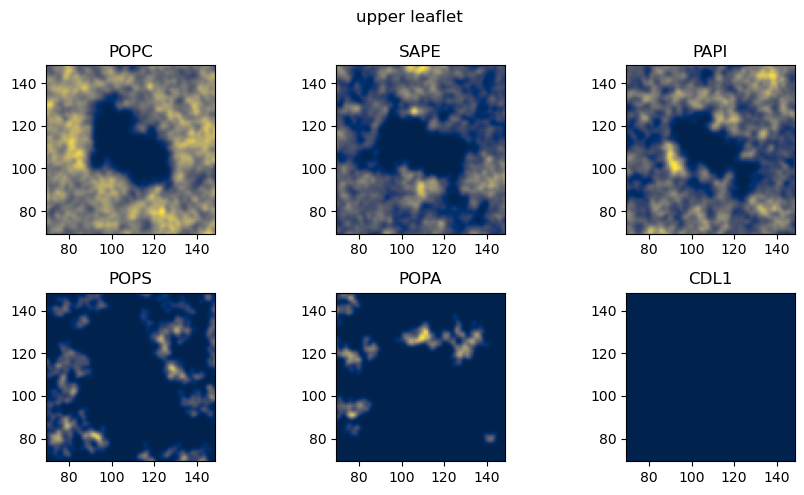

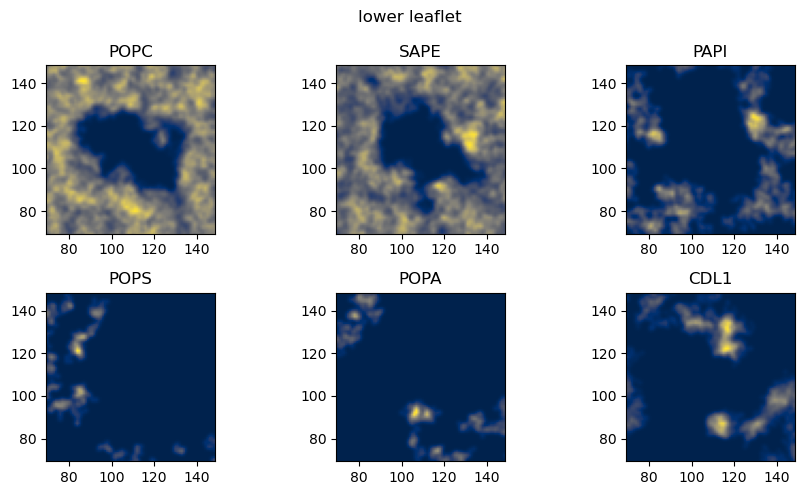

In [23]:
plot_counts(enrichment_upper)
plot_counts(enrichment_lower)